# 画像の異常検知

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 1

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 正常画像から辞書を作成

Text(0.5, 1.0, 'ok image')

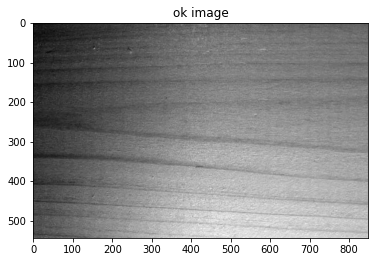

In [2]:
# 正常画像を読み込み
ok_img = np.asarray(Image.open("img/wood-ok.jpg").convert('L'))
plt.imshow(ok_img, cmap='gray')
plt.title('ok image')

In [3]:
# 正常画像は再構成できるようにしたいが、それ以外は再構成できないように、表現力を小さく設定する
patch_size = (16, 16)
n_components = 10
transform_n_nonzero_coefs = 3
max_iter = 30

In [4]:
from sklearn.preprocessing import StandardScaler
from spmimage.feature_extraction.image import extract_simple_patches_2d, reconstruct_from_simple_patches_2d

# 学習用データの用意
scl = StandardScaler()
patches = extract_simple_patches_2d(ok_img, patch_size)
patches = patches.reshape(-1, np.prod(patch_size)).astype(np.float64)
Y = scl.fit_transform(patches)

In [5]:
%%time
from spmimage.decomposition import KSVD

# 辞書学習
ksvd = KSVD(n_components=n_components, transform_n_nonzero_coefs=transform_n_nonzero_coefs, max_iter=max_iter)
X = ksvd.fit_transform(Y)
D = ksvd.components_

CPU times: user 13.6 s, sys: 1.58 s, total: 15.2 s
Wall time: 5.64 s


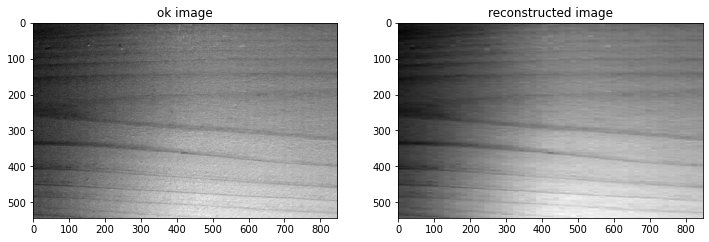

In [6]:
# 正常画像が再構成できるかどうか確かめる
reconstructed_patches = np.dot(X, D)
reconstructed_patches = scl.inverse_transform(reconstructed_patches)
reconstructed_patches = reconstructed_patches.reshape(-1, patch_size[0], patch_size[1])
reconstructed_img = reconstruct_from_simple_patches_2d(reconstructed_patches, ok_img.shape)
reconstructed_img[reconstructed_img < 0] = 0
reconstructed_img[reconstructed_img > 255] = 255
reconstructed_img = reconstructed_img.astype(np.uint8)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(ok_img, cmap='gray')
plt.title("ok image")
plt.subplot(1,2,2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title("reconstructed image")
plt.savefig("./img/result/ok-reconstruct.png")

## 異常画像を再構成
正常画像で学習された辞書を使って、異常画像に対して再構成し、そのときの再構成誤差を確認する。

Text(0.5, 1.0, 'ng image')

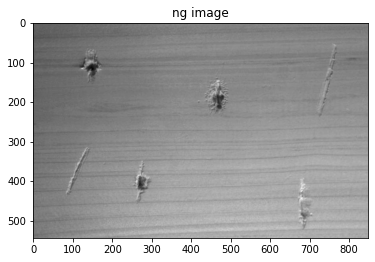

In [7]:
# 異常画像を読み込み
ng_img = np.asarray(Image.open("img/wood-ng.jpg").convert('L'))
plt.imshow(ng_img, cmap='gray')
plt.title('ng image')

In [8]:
# 異常画像に対するスパースコードを求める
patches = extract_simple_patches_2d(ng_img, patch_size)
patches = patches.reshape(-1, np.prod(patch_size)).astype(np.float64)
Y = scl.transform(patches)
X = ksvd.transform(Y)

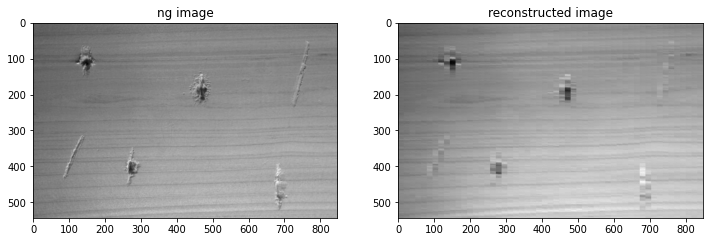

In [9]:
# 再構成画像を計算
reconstructed_patches = np.dot(X, D)
reconstructed_patches = scl.inverse_transform(reconstructed_patches)
reconstructed_patches = reconstructed_patches.reshape(-1, patch_size[0], patch_size[1])
reconstructed_img = reconstruct_from_simple_patches_2d(reconstructed_patches, ng_img.shape)
reconstructed_img[reconstructed_img < 0] = 0
reconstructed_img[reconstructed_img > 255] = 255
reconstructed_img = reconstructed_img.astype(np.uint8)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(ng_img, cmap='gray')
plt.title("ng image")
plt.subplot(1,2,2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title("reconstructed image")
plt.savefig("./img/result/ng-reconstruct.png")

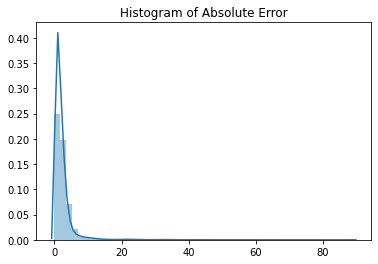

In [10]:
# 再構成誤差を計算し、ヒストグラムを描画してみる
diff_img = np.abs(np.array(ng_img, dtype=np.float) - np.array(reconstructed_img, dtype=np.float))
sns.distplot(diff_img.ravel())
plt.title("Histogram of Absolute Error")
plt.savefig("./img/result/error-hist.png")

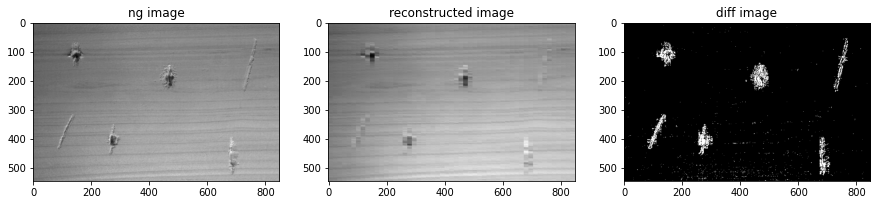

In [11]:
# 誤差が小さい部分と大きい部分で二値化を行う。
bin_diff_img = np.zeros_like(diff_img)
bin_diff_img[diff_img >= 10] = 255

# 元画像、再構成画像、diff画像を並べて描画
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(ng_img, cmap='gray')
plt.title("ng image")
plt.subplot(1,3,2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title("reconstructed image")
plt.subplot(1,3,3)
plt.imshow(bin_diff_img, cmap='gray')
plt.title("diff image")
plt.savefig("./img/result/detected-result.png")